In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
import pathlib

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from numba import jit, prange

In [4]:
from sklearn.metrics.pairwise import haversine_distances
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [5]:
DATA_DIR = pathlib.Path("../../data/")

# Loading data

In [6]:
locations = pd.read_csv(DATA_DIR.joinpath("locations.csv"), header=None)

In [7]:
locations.max()

0     78.93490
1    179.82728
dtype: float64

In [8]:
locations.columns = ["lat", "lon"]
locations["phi"] = locations["lat"] * np.pi / 180
locations["lambda"] = locations["lon"] * np.pi / 180

In [9]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494055 entries, 0 to 1494054
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   lat     1494055 non-null  float64
 1   lon     1494055 non-null  float64
 2   phi     1494055 non-null  float64
 3   lambda  1494055 non-null  float64
dtypes: float64(4)
memory usage: 45.6 MB


In [10]:
locs = gpd.GeoDataFrame(locations,
                        geometry=gpd.points_from_xy(locations["lon"], locations["lat"]))

In [11]:
def measure_time(df, f, ns=np.logspace(9, 14, 6, base=2)):
    """Measure timings for distance function `f`."""

    timings = {}

    for num in ns:
        sample = df.sample(int(num), replace=False)
        v = sample.values
        start_ts = time.time()
        distances = f(v)
        end_ts = time.time()
        timings[num] = end_ts - start_ts
    return pd.Series(timings)

# Connectivity/distance matrix

In [12]:
R0 = 6378.1

@jit(nogil=True, parallel=True)
def haversine_distances_parallel(d):
    """Numba version of haversine distance."""

    dist_mat = np.zeros((d.shape[0], d.shape[0]))

    # We parallelize outer loop to keep threads busy
    for i in prange(d.shape[0]):
        for j in range(i+1, d.shape[0]):
            sin_0 = np.sin(0.5 * (d[i, 0] - d[j, 0]))
            sin_1 = np.sin(0.5 * (d[i, 1] - d[j, 1]))
            cos_0 = np.cos(d[i, 0]) * np.cos(d[j, 0])
            dist_mat[i, j] = 2 * np.arcsin(np.sqrt(sin_0 * sin_0 + cos_0 * sin_1 * sin_1))
            dist_mat[j, i] = dist_mat[i, j]
    return R0 * dist_mat


@jit(nogil=True)
def haversine_distance(x, y):
    """Single pair Numba version of haversine distance."""

    sin_0 = np.sin(0.5 * (x[0] - y[0]))
    sin_1 = np.sin(0.5 * (x[1] - y[1]))
    cos_0 = np.cos(x[0]) * np.cos(y[0])
    return 2 * R0 * np.arcsin(np.sqrt(sin_0 * sin_0 + cos_0 * sin_1 * sin_1))


@jit(nogil=True)
def get_ci(d, thr):
    """Calculate connectivity indices in a JIT-compiled way."""

    lpairs = []
    rpairs = []

    for i in range(d.shape[0]):
        for j in range(i+1, d.shape[0]):
            distance = haversine_distance(d[i], d[j])

            if distance <= thr:
                lpairs.extend([i, j])
                rpairs.extend([j, i])
    return np.array(lpairs), np.array(rpairs)


def get_cm(coords, distance_thr):
    """Calculate connectivity matrix."""

    lpairs, rpairs = get_ci(coords, distance_thr)
    return csr_matrix((np.ones(len(lpairs), dtype=np.int8), (lpairs, rpairs)),
                      shape=(coords.shape[0], coords.shape[0]),
                      dtype=np.int8)

In [13]:
locs

,lat,lon,phi,lambda,geometry
0,42.63914,141.62366,0.744193,2.471799,POINT (141.62366 42.63914)
1,36.42835,140.61340,0.635795,2.454167,POINT (140.61340 36.42835)
2,42.63864,141.62542,0.744185,2.471830,POINT (141.62542 42.63864)
3,36.42911,140.61360,0.635808,2.454170,POINT (140.61360 36.42911)
4,36.42957,140.61429,0.635816,2.454182,POINT (140.61429 36.42957)
...,...,...,...,...,...
1494050,-1.20008,136.11359,-0.020945,2.375630,POINT (136.11359 -1.20008)
1494051,26.00627,119.47872,0.453895,2.085297,POINT (119.47872 26.00627)
1494052,33.90424,35.51669,0.591741,0.619883,POINT (35.51669 33.90424)
1494053,22.50978,120.23062,0.392870,2.098420,POINT (120.23062 22.50978)


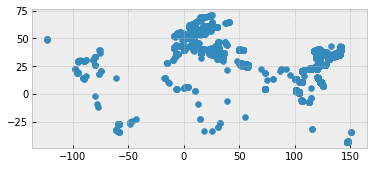

In [14]:
locs[:10000].plot()

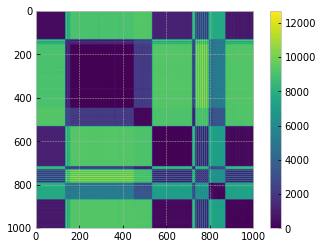

In [15]:
plt.imshow(haversine_distances_parallel(locations.loc[:1000, ["phi", "lambda"]].values))
plt.colorbar()

In [24]:
get_cm(locations.loc[:1000, ["phi", "lambda"]].values, 20)

<1001x1001 sparse matrix of type '<class 'numpy.int8'>'
	with 36208 stored elements in Compressed Sparse Row format>

# Validating the selected area

In [17]:
from shapely.geometry import box

In [18]:
Xc, Yc = 33, 33
D = 4

minx, miny, maxx, maxy = Xc - D, Yc - D, Xc + D, Yc + D
aoi = box(minx, miny, maxx, maxy)

In [19]:
aoi_locs = locs[locs.within(aoi)]

## Adding world map as a reference

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

(29.0, 37.0)

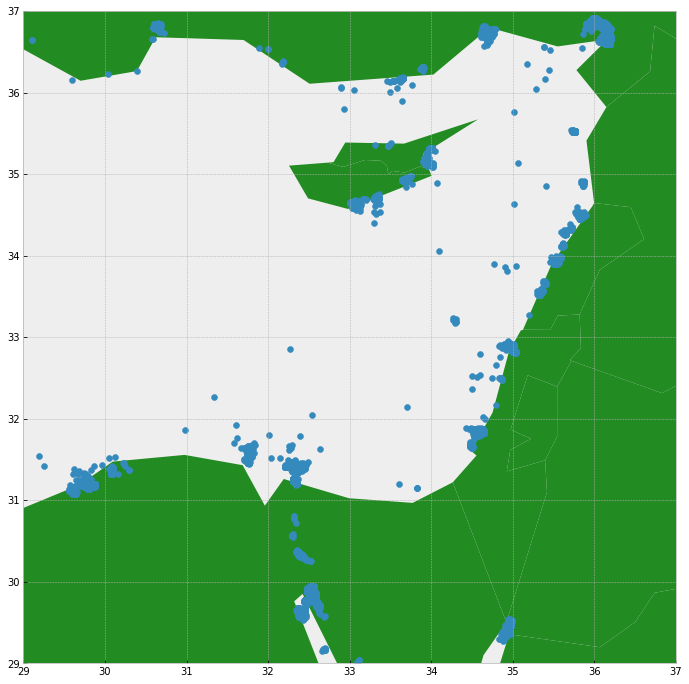

In [21]:
plt.figure(figsize=(12,12))
world.plot(color="forestgreen", ax=plt.gca())
aoi_locs.plot(ax=plt.gca())

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

In [22]:
haversine_distances_parallel(aoi_locs[["phi", "lambda"]].iloc[:1000].values)

array([[  0.        , 558.22303992, 439.2024313 , ...,   3.80731289,
          9.6738372 ,   5.16210025],
       [558.22303992,   0.        , 119.37940319, ..., 562.03027165,
        567.72060076, 562.26057467],
       [439.2024313 , 119.37940319,   0.        , ..., 443.00854103,
        448.73309896, 443.30156082],
       ...,
       [  3.80731289, 562.03027165, 443.00854103, ...,   0.        ,
          5.98960895,   3.26047178],
       [  9.6738372 , 567.72060076, 448.73309896, ...,   5.98960895,
          0.        ,   5.63632893],
       [  5.16210025, 562.26057467, 443.30156082, ...,   3.26047178,
          5.63632893,   0.        ]])

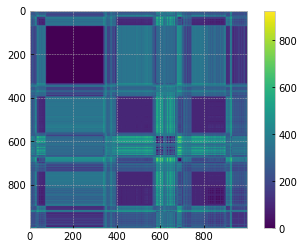

In [23]:
plt.imshow(haversine_distances_parallel(aoi_locs[["phi", "lambda"]].iloc[:1000].values))
plt.colorbar()

Distances look correct (estimate of max distance in the area is from Alexandria to Dörtyol, which is about 850 km).

# Connected components

In [25]:
THR = 20

In [26]:
cm = get_cm(aoi_locs[["phi", "lambda"]].values, THR)

In [27]:
cm

<18794x18794 sparse matrix of type '<class 'numpy.int8'>'
	with 25441986 stored elements in Compressed Sparse Row format>

In [30]:
cm.nnz

25441986

In [65]:
DENSE_GB = aoi_locs.shape[0] * aoi_locs.shape[0] / (1024 * 1024 * 1024)
SPARSE_GB = cm.nnz / (1024 * 1024 * 1024)

print("Space efficiency:", DENSE_GB / SPARSE_GB)

Space efficiency: 13.88313145050862


For the connectivity matrix of the full dataset (note that we're using `uint8`, hence one byte):

In [68]:
FULL_GB_CM = locs.shape[0] * locs.shape[0] / (1024 * 1024 * 1024)

print("CM size for the full dataset (Gb):", FULL_GB_CM / (DENSE_GB / SPARSE_GB))

CM size for the full dataset (Gb): 149.74277078154694


Still too much, we may need to consider smaller threshold (remember, that it's pairwise, hence, individual connected components at least `THR` apart, which seem reasonable to be lowered to, say, 10km).

In [35]:
n_comp, components = connected_components(cm, directed=False)

In [36]:
n_comp

54

In [37]:
components

array([ 0,  1,  2, ..., 13, 13, 15], dtype=int32)

In [39]:
aoi_locs["component"] = components

<ipython-input-39-717bf75a6d90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aoi_locs["component"] = components


In [41]:
aoi_locs.component.value_counts()

0     3016
3     2297
2     2157
1     1606
15    1432
17    1403
5     1369
13    1206
4     1003
7      770
10     747
8      525
11     370
12     264
6      160
18     132
9      104
14      97
20      34
19      23
22      12
23       7
46       7
25       6
26       4
30       3
29       3
33       3
42       3
37       3
32       3
44       2
24       2
43       1
31       1
45       1
28       1
48       1
27       1
34       1
40       1
41       1
50       1
39       1
16       1
38       1
53       1
21       1
52       1
36       1
49       1
51       1
35       1
47       1
Name: component, dtype: int64

(29.0, 37.0)

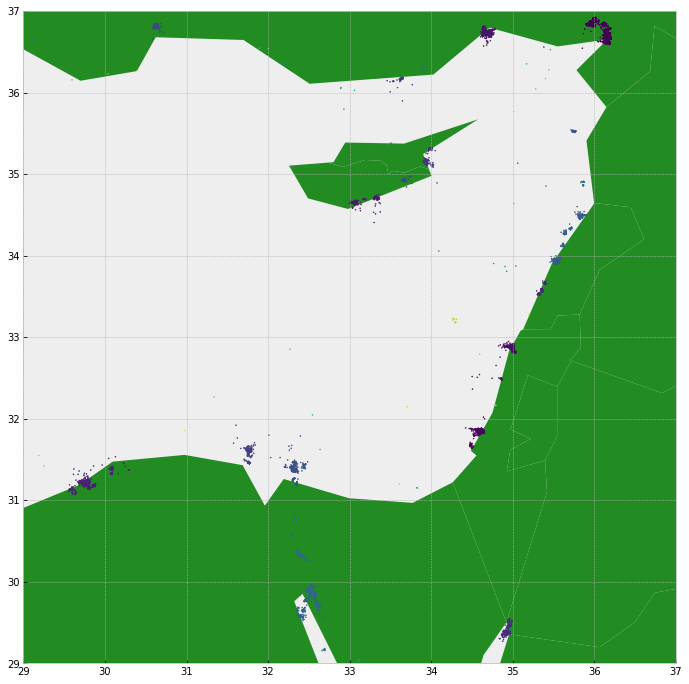

In [45]:
plt.figure(figsize=(12,12))
world.plot(color="forestgreen", ax=plt.gca())
aoi_locs.plot(column="component", ax=plt.gca(), s=1)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

The largest connected component has about 3000 vessel activities, which is 6 times smaller compared to full area activites and dramatically smaller compared to full dataset (size of connected component in the are doesn't depend on whether we calculate full location dataframe or only part of it).

In [47]:
aoi_locs[aoi_locs.component==0]

,lat,lon,phi,lambda,geometry,component
717,36.69510,36.18535,0.640450,0.631553,POINT (36.18535 36.69510),0
5813,36.69718,36.18727,0.640487,0.631587,POINT (36.18727 36.69718),0
5815,36.69877,36.18557,0.640514,0.631557,POINT (36.18557 36.69877),0
5817,36.70030,36.18182,0.640541,0.631492,POINT (36.18182 36.70030),0
5819,36.69148,36.17015,0.640387,0.631288,POINT (36.17015 36.69148),0
...,...,...,...,...,...,...
1491966,36.68247,36.19902,0.640230,0.631792,POINT (36.19902 36.68247),0
1491967,36.67943,36.19620,0.640177,0.631743,POINT (36.19620 36.67943),0
1491970,36.68843,36.19765,0.640334,0.631768,POINT (36.19765 36.68843),0
1493575,36.82389,36.11319,0.642698,0.630294,POINT (36.11319 36.82389),0


(29.0, 37.0)

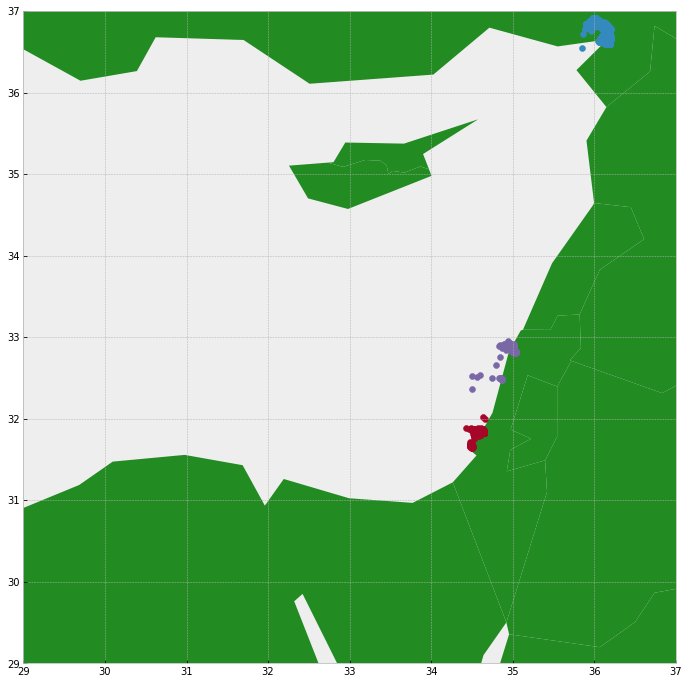

In [56]:
plt.figure(figsize=(12,12))
world.plot(color="forestgreen", ax=plt.gca())
aoi_locs[aoi_locs.component==0].plot(ax=plt.gca())
aoi_locs[aoi_locs.component==1].plot(ax=plt.gca())
aoi_locs[aoi_locs.component==2].plot(ax=plt.gca())

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

Connected components also allow us to filter activities, not related spatially to others:

In [63]:
NUM_THR = 100

component_sizes = aoi_locs.component.value_counts()
large_components = component_sizes[component_sizes>NUM_THR].index

(29.0, 37.0)

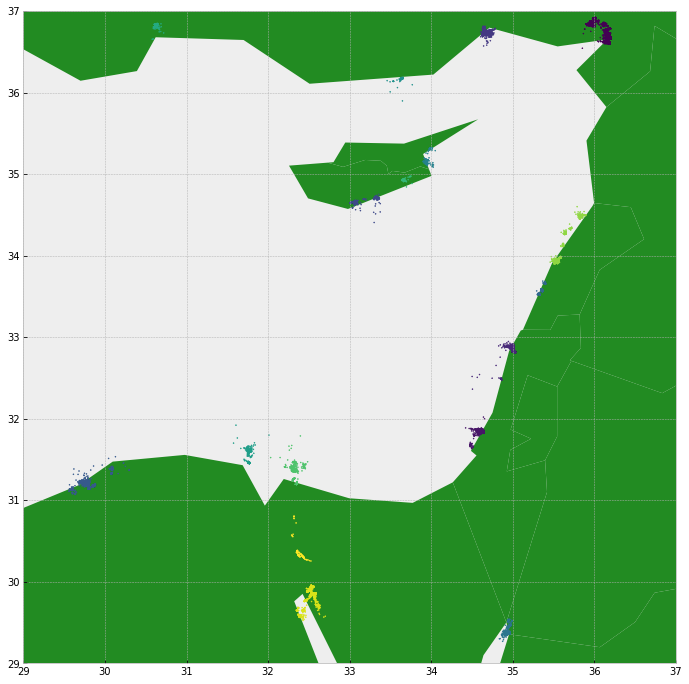

In [64]:
plt.figure(figsize=(12,12))
world.plot(color="forestgreen", ax=plt.gca())
aoi_locs[aoi_locs.component.isin(large_components)].plot(column="component", ax=plt.gca(), s=1)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

This one doesn't contain vessels floating around in the sea anymore.

# Smaller threshold

In [69]:
THR = 10

cm = get_cm(aoi_locs[["phi", "lambda"]].values, THR)

In [70]:
cm

<18794x18794 sparse matrix of type '<class 'numpy.int8'>'
	with 21034530 stored elements in Compressed Sparse Row format>

In [71]:
DENSE_GB = aoi_locs.shape[0] * aoi_locs.shape[0] / (1024 * 1024 * 1024)
SPARSE_GB = cm.nnz / (1024 * 1024 * 1024)

print("Space efficiency:", DENSE_GB / SPARSE_GB)

Space efficiency: 16.792123998016596


## Estimate of full dataset connectivity matrix size

Lowering threshold doesn't make CM much smaller (compession is only 16 compared to 13). However, we're looking at denser area, and not full dataset. If average connected component size is about `3000`, than each activity has about `3000` non-zero elements in connectivity matrix, hence overall number of non-zero elements is (in Gb):

In [75]:
3000 * locs.shape[0] / (1024 * 1024 * 1024)

4.174341447651386

This one is feasible on an EC2 machine.